In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

In [5]:
mnist = input_data.read_data_sets('data/', one_hot=True)
trainimg   = mnist.train.images
trainlabel = mnist.train.labels
testimg    = mnist.test.images
testlabel  = mnist.test.labels
print ("MNIST ready")

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
MNIST ready


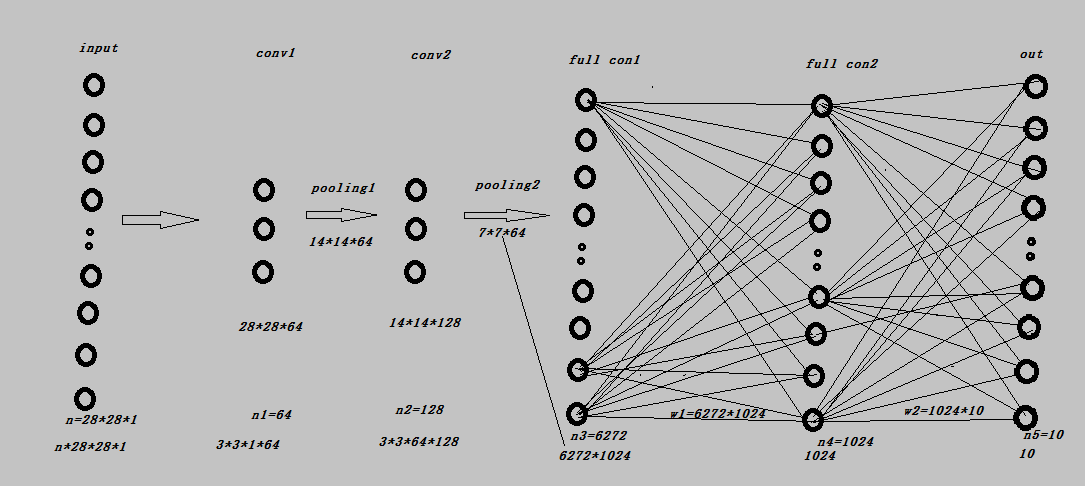

In [8]:
from IPython.display import Image
Image('CNN.png')

In [9]:
n_input  = 784
n_output = 10
weights  = {
        'wc1': tf.Variable(tf.random_normal([3, 3, 1, 64], stddev=0.1)),
        'wc2': tf.Variable(tf.random_normal([3, 3, 64, 128], stddev=0.1)),
        'wd1': tf.Variable(tf.random_normal([7*7*128, 1024], stddev=0.1)),
        'wd2': tf.Variable(tf.random_normal([1024, n_output], stddev=0.1))
    }
biases   = {
        'bc1': tf.Variable(tf.random_normal([64], stddev=0.1)),
        'bc2': tf.Variable(tf.random_normal([128], stddev=0.1)),
        'bd1': tf.Variable(tf.random_normal([1024], stddev=0.1)),
        'bd2': tf.Variable(tf.random_normal([n_output], stddev=0.1))
    }

In [14]:
def network(_input, _w, _b, _keepratio):
        # 输入，需要设置成tensorflow支持的四维格式，依次是batch_size,height,width,channel,这里的1值图片的颜色通道是1，对于RGB图片channel为3
        input_r = tf.reshape(_input, shape=[-1, 28, 28, 1])
        # 第一卷积层，使用tf.nn.conv2d方法，第一个参数为输入，第二个为卷积的参数，第三个为卷积核移动的步长通常为四个维度，分别表示在每个批次、
        #高度、宽度、通道上移动的距离，padding关键字参数用于指定padding填充的策略，SAME表示：不够滑动窗口需要填充0，VALID表示不够滑动窗口则舍弃
        conv1 = tf.nn.conv2d(input_r, _w['wc1'], strides=[1, 1, 1, 1], padding='SAME')
        #在第一层卷积的结果上增加偏置项，然后使用非线性激活函数relu对卷积的输出进行激活处理
        conv1 = tf.nn.relu(tf.nn.bias_add(conv1, _b['bc1']))
        #激活处理之后，使用max_pool进行池化，进行第一次的特征浓缩，ksize指定的是池在每个批次、高度、宽度、通道上的移动距离，strides是窗口滑动的距离
        pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        #对池化输入进行随机的dropout正则化操作，防止过拟合
        pool_dr1 = tf.nn.dropout(pool1, _keepratio)
        
        # 第二层卷积，此时conv2d的输入pool_dr1的shape为n*14*14*64,用定义的wc2卷积核进行特征提取，滑动步长都为1，padding策略为SAME
        conv2 = tf.nn.conv2d(pool_dr1, _w['wc2'], strides=[1, 1, 1, 1], padding='SAME')
        #增加偏置项并运用relu非线性激活函数
        conv2 = tf.nn.relu(tf.nn.bias_add(conv2, _b['bc2']))
        #进行池化操作，进一步特征浓缩，浓缩后数据的shape为n*7*7*128
        pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        #进行随机的dropout正则化
        pool_dr2 = tf.nn.dropout(pool2, _keepratio)
        
        #接下来是全连接层，需要将上面结构化的多维数据信息，去除结构化转换成以为的数组，pool_dr2的shape为n*7*7*128
        dense1 = tf.reshape(pool_dr2, [-1, _w['wd1'].get_shape().as_list()[0]])
        #全连接层，matmul进行全连接，加上偏置项，运用relu函数激活，返回fc1,fc1结构为n*1024
        fc1 = tf.nn.relu(tf.add(tf.matmul(dense1, _w['wd1']), _b['bd1']))
        #对fc1的输出进行随机的dropout正则化，此时的shape为n*1024
        fc_dr1 = tf.nn.dropout(fc1, _keepratio)
        
        #第二层全连接层,matmul全连接，加上偏置项
        out = tf.add(tf.matmul(fc_dr1, _w['wd2']), _b['bd2'])
        # RETURN
        out = { 'input_r': input_r, 'conv1': conv1, 'pool1': pool1, 'pool1_dr1': pool_dr1,
            'conv2': conv2, 'pool2': pool2, 'pool_dr2': pool_dr2, 'dense1': dense1,
            'fc1': fc1, 'fc_dr1': fc_dr1, 'out': out
        }
        return out
print ("CNN READY")

CNN READY


In [15]:
a = tf.Variable(tf.random_normal([3, 3, 1, 64], stddev=0.1))
print (a)
a = tf.Print(a, [a], "a: ")
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
#sess.run(a)

<tf.Variable 'Variable_19:0' shape=(3, 3, 1, 64) dtype=float32_ref>


In [42]:
#print (help(tf.nn.conv2d))
print (help(tf.nn.max_pool))

Help on function max_pool in module tensorflow.python.ops.nn_ops:

max_pool(value, ksize, strides, padding, data_format='NHWC', name=None)
    Performs the max pooling on the input.
    
    Args:
      value: A 4-D `Tensor` with shape `[batch, height, width, channels]` and
        type `tf.float32`.
      ksize: A list of ints that has length >= 4.  The size of the window for
        each dimension of the input tensor.
      strides: A list of ints that has length >= 4.  The stride of the sliding
        window for each dimension of the input tensor.
      padding: A string, either `'VALID'` or `'SAME'`. The padding algorithm.
        See the [comment here](https://www.tensorflow.org/api_docs/python/nn.html#convolution)
      data_format: A string. 'NHWC' and 'NCHW' are supported.
      name: Optional name for the operation.
    
    Returns:
      A `Tensor` with type `tf.float32`.  The max pooled output tensor.

None


In [18]:
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_output])
keepratio = tf.placeholder(tf.float32)

#调用函数network
result = network(x, weights, biases, keepratio)['out']
#使用返回结果，求损失值，这里用交叉熵，求交叉熵的均值
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=result, labels=y))
#指定使用adam优化器，learning_rate学习率为0.001，最小化损失值
optm = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

_corr = tf.equal(tf.argmax(result,1), tf.argmax(y,1)) 
accr = tf.reduce_mean(tf.cast(_corr, tf.float32)) 
init = tf.global_variables_initializer()
    
# SAVER
print ("GRAPH READY")

GRAPH READY


In [ ]:
sess = tf.Session()
sess.run(init)

training_epochs = 100
batch_size      = 24
display_step    = 2
for epoch in range(training_epochs):
    avg_cost = 0.
    
    #total_batch = int(mnist.train.num_examples/batch_size)
    total_batch = 10

    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        
        sess.run(optm, feed_dict={x: batch_xs, y: batch_ys, keepratio:0.7})
        
        avg_cost += sess.run(cost, feed_dict={x: batch_xs, y: batch_ys, keepratio:1.})/total_batch

    if epoch % display_step == 0: 
        print ("Epoch: %03d/%03d cost: %.9f" % (epoch, training_epochs, avg_cost))
        train_acc = sess.run(accr, feed_dict={x: batch_xs, y: batch_ys, keepratio:1.})
        print (" Training accuracy: %.3f" % (train_acc))

print ("OPTIMIZATION FINISHED")

Epoch: 000/100 cost: 8.064736629
 Training accuracy: 0.333
Epoch: 002/100 cost: 1.364944685
 Training accuracy: 0.583
Epoch: 004/100 cost: 1.149562085
 Training accuracy: 0.792
Epoch: 006/100 cost: 0.816925174
 Training accuracy: 0.792
Epoch: 008/100 cost: 0.725839293
 Training accuracy: 0.833
Epoch: 010/100 cost: 0.532051834
 Training accuracy: 0.958
Epoch: 012/100 cost: 0.484608662
 Training accuracy: 0.792
Epoch: 014/100 cost: 0.423562130
 Training accuracy: 0.917
Epoch: 016/100 cost: 0.358558942
 Training accuracy: 1.000
Epoch: 018/100 cost: 0.303767462
 Training accuracy: 0.917
Epoch: 020/100 cost: 0.286140318
 Training accuracy: 0.958
Epoch: 022/100 cost: 0.224471082
 Training accuracy: 0.917
Epoch: 024/100 cost: 0.191378328
 Training accuracy: 0.917
Epoch: 026/100 cost: 0.190960749
 Training accuracy: 0.917
Epoch: 028/100 cost: 0.187459631
 Training accuracy: 1.000
Epoch: 030/100 cost: 0.202060962
 Training accuracy: 0.917
Epoch: 032/100 cost: 0.207222897
 Training accuracy: 0.9